# Neumann Hamiltonian

We consider the integrable Hamiltonian

$$
H = \frac{1}{4}\sum_{\alpha,\beta} J_{\alpha\beta}^2 + \frac{1}{2}\sum_\alpha k_\alpha x_\alpha^2
$$

with $J_\alpha\beta = x_\alpha p_\beta - x_\beta p_\alpha$ is the (generalized) angular momentum. The constants of motion are

$$
I_\alpha = x_\alpha^2 + \sum_{\beta\neq \alpha} \frac{J_{\alpha\beta}^2}{k_\alpha-k_\beta}
$$

for $k_\alpha$ all different. We have

$$
H = \frac{1}{2}\sum_\alpha k_\alpha I_\alpha
$$

And

$$
\sum_\alpha x_\alpha^2 = \sum_\alpha I_\alpha,
$$

so that motion is confined to the sphere $S^{N-1}$.

## Equations of Motion

The equations of motion have Hamiltonian form

$$
\begin{align}
\dot p_\alpha &= \frac{\partial H}{\partial x_\alpha} = -k_\alpha x_\alpha-\sum_\beta \left[x_\alpha p_\beta-x_\beta p_\alpha\right]p_\beta\\
\dot x_\alpha &= -\frac{\partial H}{\partial p_\alpha} = \sum_\beta \left[p_\alpha x_\beta-p_\beta x_\alpha\right]x_\beta
\end{align}
$$

## Sample solution in TF

In [1]:
import sys
sys.path.append("../")
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt

In [2]:
from hamiltonians import parameterized_neumann
from models import NICE, SymplecticExchange, SqueezeAndShift, Chain, MLP
from utils import visualize_chain_bijector_1d, compute_loss, compute_gradients, apply_gradients

In [3]:
tf.enable_eager_execution()
tf.set_random_seed(0)

In [4]:
N = 3 
ks = np.random.rand(N)
ks = np.asfarray(ks, np.float32)

In [5]:
def join_q_p(qs, ps):
    qs = tf.expand_dims(qs, axis=1)
    ps = tf.expand_dims(ps, axis=1)
    return tf.reshape(tf.concat([qs,ps], axis=1), [-1])

In [6]:
def neumann_system(ks):
    def neumann_equations(phase_space_point, t):
        xs, ps = phase_space_point[::2], phase_space_point[1::2]
        dps = - ks * xs
        dps += -xs * tf.reduce_sum(ps**2)
        dps += ps * tf.reduce_sum(xs * ps)
        dxs = ps * tf.reduce_sum(xs**2)
        dxs += - xs * tf.reduce_sum(xs * ps)
        return join_q_p(dxs, dps)
    return neumann_equations

In [7]:
def neumann_batch(ks, size):
    N = len(ks)
    init_state = tf.random_uniform([2*N])
    t = np.linspace(0, 100, num=size)
    tensor_state, tensor_info = tf.contrib.integrate.odeint(neumann_system(ks), init_state, t, full_output=True)
    return tensor_state

In [8]:
state = neumann_batch(ks, 200).numpy()
x, px, y, py, z, pz = state.T

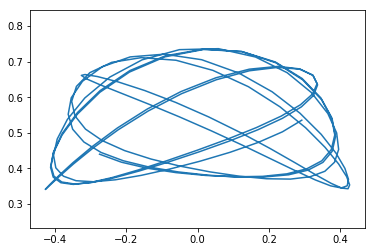

In [9]:
plt.axes().set_aspect('equal', 'datalim')
plt.plot(x, y)

## Check the integrals of motion

In [10]:
def Is(phase_space_point):
    xs, ps = phase_space_point[::2], phase_space_point[1::2]
    Is = xs**2 
    for α, _ in enumerate(Is):
        for β, _ in enumerate(Is):
            J = xs[α]*ps[β] - ps[α]*xs[β]
            if β != α:
                Is[α] += J**2 / (ks[α] - ks[β])
    return Is

In [11]:
I_traj = np.array([Is(point) for point in state])

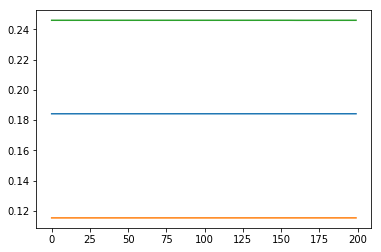

In [12]:
plt.plot(I_traj)

Check the imlementation of the Neumann Hamiltonian yields correct value

In [13]:
neumann_hamiltonian = parameterized_neumann(ks)

In [15]:
init_state = tf.random_uniform([2*N])
neumann_hamiltonian(tf.reshape(init_state, (1,-1,1)))

<tf.Tensor: id=171577, shape=(1, 1, 1), dtype=float32, numpy=array([[[0.4454786]]], dtype=float32)>

In [16]:
np.sum(ks*Is(init_state.numpy())) / 2

0.445478618144989

## Learning a Transformation

In [17]:
# Suppress the warning till they fix this:
# lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:75: 
# DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
import warnings
warnings.filterwarnings("ignore")

In [18]:
DTYPE=tf.float32
NP_DTYPE=np.float32
settings = {
    'hamiltonian': parameterized_neumann(ks), 
    'phase_space_dim': 2*N, 
    'batch_size': 256,    # Mini batch size 
    'num_bijectors': 4,   # Number of bijectors
    'train_iters': 1e5}   # Number of training iterations

In [19]:
bijectors = [SqueezeAndShift(shift_model=MLP(return_gradient=True,activation=tf.tanh)) if i % 2 == 0 
             else SymplecticExchange() 
             for i in range(settings['num_bijectors'])]
model = Chain(bijectors)

Training

In [20]:
import time
start_time = time.time()

optimizer = tf.train.AdamOptimizer(1e-4)

# TODO: implement early stopping? / decrease learning rate over time

global_step = []
losses = []
gradients_norms = []
for epoch in range(int(1e4)):
    z_samples = tf.expand_dims(neumann_batch(ks, settings['batch_size']),-1)
    gradients, loss = compute_gradients(model, settings['hamiltonian'], z_samples)
    apply_gradients(optimizer, gradients, model.trainable_variables)
    # Visualization
    if epoch % 1e2 == 0:
        global_step.append(epoch)
        losses.append(loss.numpy())
        gradients_norms.append([tf.norm(gradients[i]).numpy() for i in range(len(gradients))])        
    if epoch % int(1e2) == 0:
        print(epoch, loss.numpy())
end_time = time.time()
print("Time elapsed: ", end_time - start_time)

0 0.828239
100 0.053839374
200 0.119180456
300 0.31869155
400 0.25974792
500 0.67595285
600 0.5767895
700 0.60481304
800 0.32144487
900 0.020254634
1000 0.7399962
1100 0.32766926
1200 0.37224227
1300 0.37062848
1400 0.6221596
1500 0.076110944
1600 0.18047166


KeyboardInterrupt: 